# 1 가격정보 조회(수정주가)

In [16]:
import datetime
import requests
import pandas as pd
import xml.etree.ElementTree as ET

def getStockPrice(StockCode, Count = 252) :
    ret = pd.DataFrame(columns=['date', 'open', 'high', 'low', 'adjclose','volume'])
    
    url = "https://fchart.stock.naver.com/sise.nhn?symbol={}&timeframe=day&count={}&requestType=0"
    url = url.format(StockCode, Count)
    response = requests.get(url)
    
    e = ET.fromstring(response.text.replace('\n','').replace('\t',''))
    
    stock_history = []
    for item in e.find('chartdata').findall('item') :
        data = item.get('data').split('|')
        ret.loc[len(ret)] = [datetime.datetime.strptime(data[0],"%Y%m%d").date(),float(data[1]),float(data[2]),float(data[3]),float(data[4]),int(data[5])]
       
    ret = ret.set_index('date')
    return ret

In [17]:
df = getStockPrice('005930')[['adjclose']]
df.tail()

adjclose
date                
2019-07-01   46600.0
2019-07-02   46250.0
2019-07-03   45400.0
2019-07-04   46000.0
2019-07-05   45550.0

In [18]:
import numpy as np

def getLogReturns(df_price) :
  logReturn = np.log(df_price / df_price.shift(1))
  logReturn = logReturn.dropna()
  return logReturn

SEC_price = getStockPrice('005930')[['adjclose']]
SEC_return = getLogReturns(SEC_price)

KOSPI_price = getStockPrice('KOSPI')[['adjclose']]
KOSPI_return = getLogReturns(KOSPI_price)

In [19]:
SEC_return.head()

adjclose
date                
2018-06-28 -0.024276
2018-06-29 -0.003210
2018-07-02 -0.023862
2018-07-03  0.013086
2018-07-04  0.002165

# 2 통계데이터(수익률의 평균, 분산)

In [5]:
def mean(returns):       
    sum = 0
    for i in range(len(returns)): 
        sum = sum + returns.iloc[i] 
      
    return sum / len(returns) 

In [6]:
SEC_mean = mean(SEC_return)
#SEC_return.mean()

SEC_mean

adjclose   -0.000209
dtype: float64

In [7]:
KOSPI_mean = mean(KOSPI_return)
KOSPI_mean

adjclose   -0.000416
dtype: float64

In [8]:
def std(returns) :
  sum = 0.0
  sqrsum = 0.0
  for i in range(len(returns)):
      sum += (float)(returns.iloc[i])
      sqrsum += (float)(returns.iloc[i]) * (float)(returns.iloc[i])

  mean = sum / len(returns)
  sqrmean = sqrsum / len(returns)

  stdev = sqrmean - mean * mean
  stdev = np.power(stdev, 1/2)

  return stdev


def volatility(returns) :

  return std(returns) * np.sqrt(252)

volatility(SEC_return)

0.24489644298463364

In [9]:
SEC_return.std() * np.sqrt(252)

adjclose    0.245386
dtype: float64

# 3 종목별 역사적 변동성 조회

In [10]:
def getHistoricalVolatility(StockCode, Count = 252):
  price = getStockPrice(StockCode)[['adjclose']]
  returns = getLogReturns(price)
    
  return volatility(returns)

In [11]:
getHistoricalVolatility('005930')

0.24489644298463364

In [12]:
getHistoricalVolatility('KOSPI')

0.13632876465984442

# 4 공분산, 상관계수

In [13]:
def covariance(return1, return2): 
  
    sum = 0.0
    for i in range(len(return1)): 
      sum = (sum + (return1.iloc[i] - mean(return1)) *
                    (return2.iloc[i] - mean(return2))) 
      
    return sum / (len(return1) - 1) 

In [14]:
covariance(SEC_return, KOSPI_return)

adjclose    0.0001
dtype: float64

In [15]:
np.cov(SEC_return['adjclose'].to_numpy(), KOSPI_return['adjclose'].to_numpy())

array([[2.38945099e-04, 9.99941629e-05],
       [9.99941629e-05, 7.40471198e-05]])

In [0]:
SEC_return.merge(KOSPI_return, left_index=True, right_index=True).cov()

adjclose_x  adjclose_y
adjclose_x     0.00024    0.000100
adjclose_y     0.00010    0.000074

In [0]:
def correlation(return1, return2) :
  cov = covariance(return1, return2)
  vol1 = std(return1)
  vol2 = std(return2)
  
  return cov/(vol1*vol2)


In [0]:
correlation(SEC_return, KOSPI_return)

adjclose    0.750971
dtype: float64

In [0]:
stock_list = ['KOSPI','005930','000660','068270','207940','005380','005490','051910','028260','035420','012330']

df = pd.DataFrame()

for stock in stock_list :
  price = getStockPrice(stock)[['adjclose']]
  returns = getLogReturns(price)
  
  returns = returns.rename(columns={"adjclose": stock})
  
  df= df.merge(returns, left_index=True, right_index=True, how='outer')


df.head()

KOSPI    005930    000660  ...    028260    035420    012330
date                                      ...                              
2018-06-27 -0.003789  0.020011  0.010620  ...  0.008511  0.005426 -0.011534
2018-06-28 -0.011937 -0.024276 -0.020155  ... -0.012793  0.010765 -0.006985
2018-06-29  0.005125 -0.003210  0.026006  ...  0.000000  0.021196 -0.009390
2018-07-02 -0.023748 -0.023862 -0.023614  ... -0.012959 -0.015856 -0.031140
2018-07-03  0.000537  0.013086  0.028270  ... -0.021979 -0.005340 -0.002436

[5 rows x 11 columns]

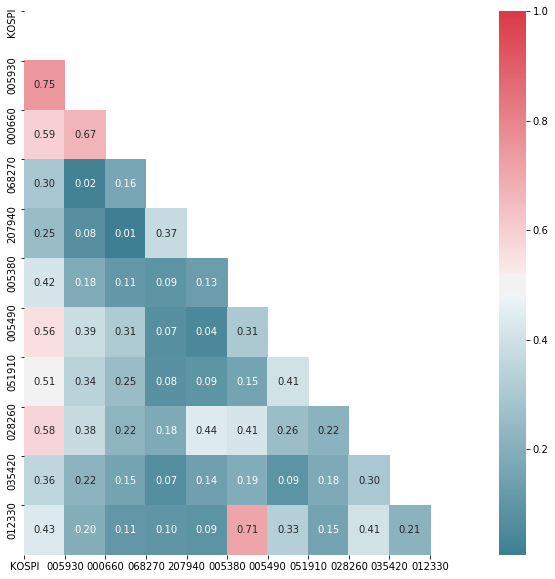

In [0]:
import seaborn as sns

# Create Correlation df
corr = df.corr()
# Plot figsize
fig, ax = plt.subplots(figsize=(10, 10))
# Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)

# Drop self-correlations
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
# Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)
# Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
# Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
# Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
# show plot
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


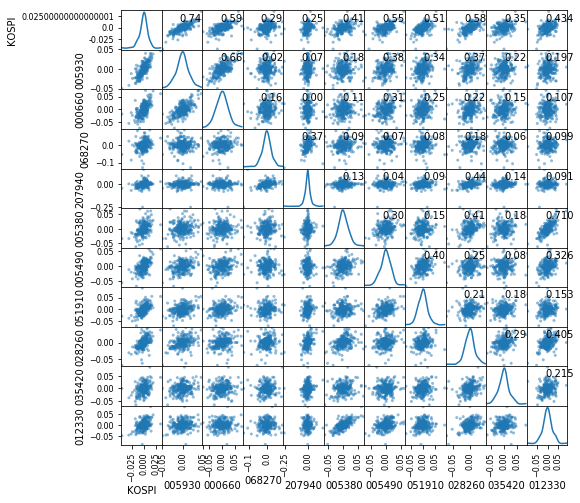

In [31]:
import matplotlib.pyplot as plt
import matplotlib.pylab as plt


import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix

plt.rcParams["figure.figsize"] = (8,8)
axes = scatter_matrix(df, alpha=0.5, diagonal='kde')
corr = df.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

# 5 베타

In [0]:
def beta(return1, return2) :
  cov = covariance(return1, return2)
  vol2 = std(return2)
  
  return cov/(vol2*vol2)

beta(SEC_return, KOSPI_return)

adjclose    1.351908
dtype: float64